In [1]:
import json
import pickle
from collections import deque

import gym
import numpy as np
from bottleneck import move_mean
from gym import logger
from gym.wrappers import Monitor


In [2]:
class RandomAgent:
    """
    Base class for Reinforcement Learning agent
    """

    def __init__(self, config):

        # Running configuration
        self.run = 0
        self.step = 0
        self.episode = 0
        self.episode_count = config['EPISODES']

        # Env
        self.env_id = config['ENV_ID']
        self.env_seed = config['ENV_SEED']
        if config['VERBOSE'] > 0:
            self.env = Monitor(gym.make(self.env_id), directory=config['RECORD_DIR'] + f'run_{self.run}',
                               video_callable=lambda episode_id: episode_id % config['SAVE_EVERY'] == 0,
                               force=True,
                               uid=config['AGENT'])
        else:
            self.env = gym.make(self.env_id)
        self.env.seed(self.env_seed)

        # generating a random number
        self.prng = np.random.RandomState(self.env_seed)

        self.score = deque(maxlen=self.episode_count)
        self.score_100 = deque(maxlen=100)  # last 100 mean

    def act(self, *args):
       
        #Performing a random action
        
        return self.prng.randint(self.env.action_space.n)

    def do_episode(self, config):

        # Initial values
        done = False
        score_e = 0
        step_e = 0

        # Reset environment
        self.env.reset()

        while not done:

            # display on screen
            if config['VERBOSE'] > 1:
                self.env.render()

            # Action
            action = self.act()
            _, reward, done, _ = self.env.step(action)

            # Increase the score and steps
            score_e += reward
            step_e += 1
            self.step += 1

        # Appending the score
        self.score.append(score_e)
        self.score_100.append(score_e)
        mean_score = np.mean(self.score_100)

        # Increasing the episodes
        self.episode += 1

        if config['VERBOSE'] > 0:
            logger.info(f'[Episode {self.episode}] - score: {score_e:.2f}, steps: {step_e}, '
                        f'100-score: {mean_score:.2f}.')

    def get_best_score(self):

        # Best score is the highest 100-episode score that is reached when score < 200,
        # or the episode when score >= 200
        score_100 = move_mean(self.score, window=(100 if len(self.score) > 99 else len(self.score)), min_count=1)

        # Get max
        ep_max = np.argmax(score_100)
        score_max = score_100[ep_max]

        if score_max >= 200.0:
            ep_max = np.argmax(score_100 >= 200.0)
            score_max = 200.0

        return int(ep_max), float(score_max)

    def save_checkpoint(self, config):

        #Configuring Parameters
        dummy_env = self.env
        self.env = None

        # Save checkpoint
        with open(config['RECORD_DIR'] + 'checkpoint.pickle', 'wb') as p_file:
            pickle.dump(self, p_file)

        # Save config
        with open(config['RECORD_DIR'] + 'config.json', 'w') as c_file:
            json.dump(config, c_file, sort_keys=True, indent=4)

        self.env = dummy_env

        
class SarsaAgent(RandomAgent):
    """
    Agent that makes use of Sarsa (on-policy TD control).
    """

    def __init__(self, config):

        # Initialize base class
        super().__init__(config)

        # State
        self.state_bounds = config['STATE_BOUNDS']
        self.state_bins = tuple(config['STATE_BINS'])

        # Float conversion
        for i, lr in enumerate(config['LEARNING_RATE']):
            if type(lr) is str:
                config['LEARNING_RATE'][i] = float(lr)
        for i, eps in enumerate(config['E_GREEDY']):
            if type(eps) is str:
                config['E_GREEDY'][i] = float(eps)

        # Learning parameters
        # First linear decay, then exponential decay
        self.alpha_start, self.alpha_end, self.alpha_steps, self.alpha_decay = config['LEARNING_RATE']
        self.epsilon_start, self.epsilon_end, self.epsilon_steps, self.epsilon_decay = config['E_GREEDY']
        self.alpha, self.epsilon = self.alpha_start, self.epsilon_start
        self.gamma = float(config['DISCOUNT_RATE'])

        # Q-table
        self.q_table = self.prng.uniform(low=-1.0, high=1.0, size=self.state_bins + (self.env.action_space.n,))

    def act(self, state):

        if self.prng.random_sample() < self.epsilon:
            return self.prng.randint(self.env.action_space.n)
        else:
            return np.argmax(self.q_table[state])

    def discretize_state(self, state):

        # First calculate the ratios, then convert to bin indices
        ratios = [(state[i] + abs(self.state_bounds[i][0])) / (self.state_bounds[i][1] - self.state_bounds[i][0]) for i
                  in range(len(state))]
        state_d = [int(round((self.state_bins[i] - 1) * ratios[i])) for i in range(len(state))]
        state_d = [min(self.state_bins[i] - 1, max(0, state_d[i])) for i in range(len(state))]

        return tuple(state_d)

    def learn(self, done, state, action, reward, state_, action_):

        # Get current Q(s, a)
        q_value = self.q_table[state][action]

        # Check if next state is terminal, get next Q(s', a')
        if not done:
            q_value_ = reward + self.gamma * self.q_table[state_][action_]
        else:
            q_value_ = reward

        # Update current Q(s, a)
        self.q_table[state][action] += self.alpha * (q_value_ - q_value)

    def do_episode(self, config):

        # Initial values
        done = False
        score_e = 0
        step_e = 0

        # Get epsilon for initial state
        self.update_epsilon_step()

        # Episodic decay (only after linear decay)
        self.update_alpha_episode()
        self.update_epsilon_episode()

        # Get current state s, act based on s
        state = self.discretize_state(self.env.reset())
        action = self.act(state)

        while not done:

            # Show on screen
            if config['VERBOSE'] > 1:
                self.env.render()

            # Update for other steps
            self.update_alpha_step()
            self.update_epsilon_step()

            # Get next state s' and reward, act based on s'
            state_, reward, done, _ = self.env.step(action)
            state_ = self.discretize_state(state_)
            action_ = self.act(state_)

            # Learn
            self.learn(done, state, action, reward, state_, action_)

            # Set next state and action to current
            state = state_
            action = action_

            # Increasing score and steps
            score_e += reward
            step_e += 1
            self.step += 1

        # Appending score
        self.score.append(score_e)
        self.score_100.append(score_e)
        mean_score = np.mean(self.score_100)

        # Increasing episode
        self.episode += 1

        if config['VERBOSE'] > 0:
            logger.info(f'[Episode {self.episode}] - score: {score_e:.2f}, steps: {step_e}, e: {self.epsilon:.4f}, '
                        f'a: {self.alpha:.4f}, 100-score: {mean_score:.2f}.')

    def update_alpha_step(self):

        # Linear decay
        if self.step <= self.alpha_steps and self.alpha_steps > 0:
            self.alpha = self.alpha_start - self.step * (self.alpha_start - self.alpha_end) / self.alpha_steps

    def update_epsilon_step(self):

        # Linear decay
        if self.step <= self.epsilon_steps and self.epsilon_steps > 0:
            self.epsilon = self.epsilon_start - self.step * (self.epsilon_start - self.epsilon_end) / self.epsilon_steps

    def update_alpha_episode(self):

        # Exponential decay
        if self.step > self.alpha_steps:
            self.alpha *= self.alpha_decay

    def update_epsilon_episode(self):

        # Exponential decay
        if self.step > self.epsilon_steps:
            self.epsilon *= self.epsilon_decay


In [3]:
import pickle

import gym
import matplotlib.pyplot as plt
from bottleneck import move_mean
from gym.wrappers import Monitor

In [4]:

def prepare_plots():

    # Interactive, style
    plt.ion()

    # Get figure and subplots
    figure = plt.figure(figsize=(10, 5))
    axes = [figure.add_subplot(111)]  # 121), figure.add_subplot(122)]

    # Configure subplots
    axes[0].set_xlabel('episode [-]')
    axes[0].set_ylabel('score [-]')
    axes[0].set_title('Score moving average', fontstyle='italic')
    # axes[1].set_xlabel('episode')
    # axes[1].set_ylabel('score')
    # axes[1].set_title('Score moving average over episodes', fontstyle='italic')

    # Get lines
    lines = [axes[0].plot([0])[0]]

    return figure, axes, lines


def update_plots(figure, axes, lines, episode, score):

    # Moving average
    score_ma = move_mean(score, window=(100 if len(score) > 99 else len(score)), min_count=1)

    # Update plot
    lines[0].set_data(range(1, episode + 1), score_ma)

    # Rescale axes
    for ax in axes:
        ax.relim()
        ax.autoscale_view()

    # Update figure
    figure.tight_layout()
    figure.canvas.draw()
    figure.canvas.flush_events()

    return figure


In [5]:
import argparse
import os

import numpy as np
import yaml
from gym import logger



In [6]:
config = 'config/config_sarsa.yaml'

In [7]:
with open(config, 'r') as config_file:
    config = yaml.load(config_file)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [8]:
config

{'ENV_ID': 'LunarLander-v2',
 'ENV_SEED': 0,
 'AGENT': 'sarsa',
 'RECORD_DIR': 'record/sarsa/',
 'CHECKPOINT_DIR': '',
 'EPISODES': 8000,
 'SAVE_EVERY': 100,
 'STATE_BINS': [5, 5, 5, 5, 5, 5, 2, 2],
 'STATE_BOUNDS': [[-1.0, 1.0],
  [-1.0, 1.0],
  [-1.0, 1.0],
  [-1.0, 1.0],
  [-1.0, 1.0],
  [-1.0, 1.0],
  [-1.0, 1.0],
  [-1.0, 1.0]],
 'VERBOSE': 1,
 'CONTINUE': False,
 'E_GREEDY': [1.0, 0.05, '1e5', 0.99],
 'LEARNING_RATE': [0.2, 0.2, 0, 1],
 'DISCOUNT_RATE': 0.97}

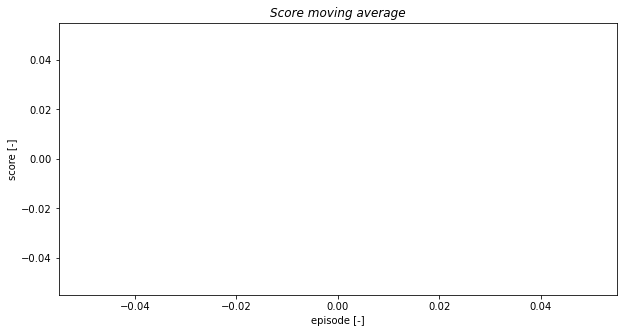

In [9]:
if not os.path.exists(config['RECORD_DIR']):
    os.makedirs(config['RECORD_DIR'])
if config['VERBOSE'] > 0:
    figure, axes, lines = prepare_plots()
else:
    figure, axes, lines = None, None, None


In [10]:
agent = SarsaAgent(config)

In [11]:
config['VERBOSE']= 0

In [ ]:
 while agent.episode < agent.episode_count:

        # Do episode
        agent.do_episode(config)

        # Update plots
        if config['VERBOSE'] > 0:
            figure = update_plots(figure, axes, lines, agent.episode, agent.score)

        # Save every nth episode
        if agent.episode % config['SAVE_EVERY'] == 0 and config['VERBOSE'] > 0:
            agent.save_checkpoint(config)
            figure.savefig(config['RECORD_DIR'] + 'score.pdf')

        # Break when goal of 100-score > 200 is reached
        if np.mean(agent.score_100) >= 200.0:
            if config['VERBOSE'] > 0:
                agent.save_checkpoint(config)
                figure.savefig(config['RECORD_DIR'] + 'score.pdf')
            logger.info('Goal reached!')
            break

    # Close
agent.env.close()